In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('../../../data/kc_house_data_binned.csv')

In [3]:
to_square = ['median_prce','years_since_new','long','sqft_lot']
for col in to_square:
    data[col+'_man_sq'] = data[col]**2

In [4]:
data['median_prce_comfort_index_man_x'] = data['median_prce']*data['comfort_index']

In [5]:
def relevants(data):
    rel = []
    for col in data.columns:
        if data[col].dtype != object:
            rel.append(col)
    return rel

def graphs(data):
    relevant = relevants(data.drop('price', axis = 1))
    rowsplot = int(len(relevant)/2 + 1)

    fig, axes = plt.subplots(nrows = rowsplot, ncols = 2, figsize=(20, 130))

    for col, ax in zip(relevant, axes.flatten()):
        sns.scatterplot(data = data, x = col, y = 'price', ax = ax)
        ax.set_title(col, fontsize = 20)
        
def make_corrs(data, display = False):
    corrs = data.corr().stack().reset_index()
    corrs = corrs.loc[corrs['level_0'] != corrs['level_1']]
    corrs['pair'] = corrs['level_0'] + ' '+ corrs['level_1']
    corrs['pair'] = corrs['pair'].map(lambda x: ', '.join(sorted(x.split(' '))))
    corrs.drop_duplicates(subset = 'pair', inplace = True)
    corrs.drop(['level_1','level_0'], axis = 1, inplace = True)
    corrs.set_index('pair', inplace = True)
    corrs.columns = pd.Series('correlation')
    corrs = abs(corrs).sort_values('correlation', ascending = False)
    if display:
        display(corrs)
    return corrs

def make_high_corrs(data, display = False):
    corrs = make_corrs(data)
    high_corrs = corrs.loc[corrs['correlation']>= 0.75]
    if display:
        display(high_corrs)
    return high_corrs

def make_corrs_with_price(data, display = False):
    corrs = make_corrs(data)
    corrs_with_price = corrs.loc[corrs.index.str.contains('price')]
    if display:
        display(corrs_with_price)
    return corrs_with_price

def check_homoscedastic(data, display = False):
    results = []
    for col in data.drop('price', axis = 1).columns:
        lower = data[col].quantile(0.45)
        upper = data[col].quantile(0.55)
        mids = data.loc[(data[col] >= lower)&(data[col] <= upper)].index

        index = [x for x in data.index if x not in mids]
        formula = f'price~{col}'
        model = smf.ols(formula = formula, data = data).fit()

        results.append((col, sms.het_goldfeldquandt(model.resid.iloc[index], model.model.exog[index])[1]))

    heteroscedastic = [(col, p) for col, p in results if p < 0.05]
    if display:
        print(heteroscedastic)
    
    return heteroscedastic, results

def corr(x, y):
    xbar = x.mean()
    ybar = y.mean()
    return sum((x-xbar)*(y-ybar))/np.sqrt(sum((x-xbar)**2)*sum((y-ybar)**2))



In [6]:
poly = PolynomialFeatures(2)
data_cop = data.drop(['price','date','zipcode','datefloat','act_prce','id'], axis = 1)
poly.fit(data_cop)
X = pd.DataFrame(poly.transform(data_cop), columns = poly.get_feature_names(data_cop.columns), index = data_cop.index)
y = data['price']
print(len(X.columns))
linreg = LinearRegression()

1225


In [7]:
print(X.columns)

Index(['1', 'sqft_lot', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long',
       ...
       'years_since_new_man_sq^2', 'years_since_new_man_sq long_man_sq',
       'years_since_new_man_sq sqft_lot_man_sq',
       'years_since_new_man_sq median_prce_comfort_index_man_x',
       'long_man_sq^2', 'long_man_sq sqft_lot_man_sq',
       'long_man_sq median_prce_comfort_index_man_x', 'sqft_lot_man_sq^2',
       'sqft_lot_man_sq median_prce_comfort_index_man_x',
       'median_prce_comfort_index_man_x^2'],
      dtype='object', length=1225)


In [8]:
categoricals = ['bedrooms','bathrooms','floors','waterfront','view','condition','renovated']

In [9]:
dropped = 0
for cat in categoricals:
    cols = X.columns[X.columns.str.contains(cat)]
    for col in cols:
        if len(col.split(' ')) == 2:
            factors = col.split(' ')
            if factors[0].split('_')[0] == factors[1].split('_')[0]:
                print(f'Removing {col}', end = '--')
                dropped += 1
                X.drop(col, axis = 1, inplace = True)
                
        else:
            if '^' in col:
                print(f'Removing {col}', end = '--')
                dropped += 1
                X.drop(col, axis = 1, inplace = True)

Removing bedrooms_few^2--Removing bedrooms_few bedrooms_norm--Removing bedrooms_few bedrooms_many--Removing bedrooms_norm^2--Removing bedrooms_norm bedrooms_many--Removing bedrooms_many^2--Removing bathrooms_few^2--Removing bathrooms_few bathrooms_norm--Removing bathrooms_few bathrooms_many--Removing bathrooms_norm^2--Removing bathrooms_norm bathrooms_many--Removing bathrooms_many^2--Removing floors_low^2--Removing floors_low floors_norm--Removing floors_low floors_many--Removing floors_norm^2--Removing floors_norm floors_many--Removing floors_many^2--Removing waterfront^2--Removing view_none^2--Removing view_none view_avg--Removing view_none view_good--Removing view_avg^2--Removing view_avg view_good--Removing view_good^2--Removing condition_awful^2--Removing condition_awful condition_avg--Removing condition_awful condition_good--Removing condition_avg^2--Removing condition_avg condition_good--Removing condition_good^2--Removing yr_built yr_renovated--Removing yr_renovated^2--Removing

In [10]:
dropped

34

In [11]:
X.columns

Index(['1', 'sqft_lot', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long',
       ...
       'years_since_new_man_sq^2', 'years_since_new_man_sq long_man_sq',
       'years_since_new_man_sq sqft_lot_man_sq',
       'years_since_new_man_sq median_prce_comfort_index_man_x',
       'long_man_sq^2', 'long_man_sq sqft_lot_man_sq',
       'long_man_sq median_prce_comfort_index_man_x', 'sqft_lot_man_sq^2',
       'sqft_lot_man_sq median_prce_comfort_index_man_x',
       'median_prce_comfort_index_man_x^2'],
      dtype='object', length=1191)

In [12]:
dropped = 0
for col in X.columns:
    if X[col].nunique() == 1:
        X.drop(col, axis = 1, inplace = True)
        dropped+=1

In [13]:
dropped

11

In [14]:
X.columns

Index(['sqft_lot', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       ...
       'years_since_new_man_sq^2', 'years_since_new_man_sq long_man_sq',
       'years_since_new_man_sq sqft_lot_man_sq',
       'years_since_new_man_sq median_prce_comfort_index_man_x',
       'long_man_sq^2', 'long_man_sq sqft_lot_man_sq',
       'long_man_sq median_prce_comfort_index_man_x', 'sqft_lot_man_sq^2',
       'sqft_lot_man_sq median_prce_comfort_index_man_x',
       'median_prce_comfort_index_man_x^2'],
      dtype='object', length=1180)

In [15]:
folds = KFold(n_splits = 5, shuffle = True)
from sklearn.metrics import r2_score, mean_squared_error
rmse = lambda y, yhat: mean_squared_error(y, yhat, squared = False)
def five_fold(X, y, say = False):
    if say:
        print('KFOLDS')
    trains = []
    tests = []
    count = 0
    for tr_ind, te_ind in folds.split(X):
        X_train, X_test = X.iloc[tr_ind], X.iloc[te_ind]
        y_train, y_test = y.iloc[tr_ind], y.iloc[te_ind]
        if len(np.array(X_train).shape) != 1:
            linreg.fit(X_train, y_train)
            trains.append(linreg.score(X_train, y_train))
            tests.append(linreg.score(X_test, y_test))
        else:
            X_train = np.array(X_train).reshape(-1,1)
            X_test = np.array(X_test).reshape(-1,1)
            linreg.fit(X_train, y_train)
            trains.append(linreg.score(X_train, y_train))
            tests.append(linreg.score(X_test, y_test))
        count +=1

    return sum(trains)/5, sum(tests)/5

def five_fold_rmse(X, y, say = False):
    if say:
        print('KFOLDS')
    trains = []
    tests = []
    count = 0
    for tr_ind, te_ind in folds.split(X):
        X_train, X_test = X.iloc[tr_ind], X.iloc[te_ind]
        y_train, y_test = y.iloc[tr_ind], y.iloc[te_ind]
        if len(np.array(X_train).shape) != 1:
            linreg.fit(X_train, y_train)
            trains.append(rmse(np.exp(linreg.predict(X_train)), np.exp(y_train)))
            tests.append(rmse(np.exp(linreg.predict(X_test)), np.exp(y_test)))
        else:
            X_train = np.array(X_train).reshape(-1,1)
            X_test = np.array(X_test).reshape(-1,1)
            linreg.fit(X_train, y_train)
            trains.append(rmse(np.exp(linreg.predict(X_train)), np.exp(y_train)))
            tests.append(rmse(np.exp(linreg.predict(X_test)), np.exp(y_test)))
        count +=1

    return sum(trains)/5, sum(tests)/5

def five_fold_rmse_logged(X, y, say = False):
    if say:
        print('KFOLDS')
    trains = []
    tests = []
    count = 0
    for tr_ind, te_ind in folds.split(X):
        X_train, X_test = X.iloc[tr_ind], X.iloc[te_ind]
        y_train, y_test = y.iloc[tr_ind], y.iloc[te_ind]
        if len(np.array(X_train).shape) != 1:
            linreg.fit(X_train, y_train)
            trains.append(rmse(linreg.predict(X_train), y_train))
            tests.append(rmse(linreg.predict(X_test), y_test))
        else:
            X_train = np.array(X_train).reshape(-1,1)
            X_test = np.array(X_test).reshape(-1,1)
            linreg.fit(X_train, y_train)
            trains.append(rmse(linreg.predict(X_train), y_train))
            tests.append(rmse(linreg.predict(X_test), y_test))
        count +=1

    return sum(trains)/5, sum(tests)/5

In [16]:
import copy
def find_best(X, y, initial):
    while 1:
        changed = 0
        if len(initial) != 0:
            init_train, init_test = five_fold(X[initial], y)
        else:
            init_train, init_test = 0, 0
        print(initial)
        addition = 0
        added = ''
        for col in X.drop(initial, axis = 1).columns:
            new = copy.copy(initial)
            new.append(col)
            train_sc, test_sc = five_fold(X[new], y)
            if (test_sc > addition) and (test_sc > init_test) and (abs(test_sc - train_sc) < 0.07):
                addition = test_sc
                added = col
        if addition != 0:
            changed = 1
            initial.append(added)
            print(f'Added {added} with score {addition}')
        
        if len(initial) != 0:
            init_train, init_test = five_fold(X[initial], y)
        else:
            init_train, init_test = 0, 0
        print(initial)
        removal = 0
        removed = ''
        for col in initial:
            new = copy.copy(initial)
            new.remove(col)
            if len(new) == 0:
                break
            train_sc, test_sc = five_fold(X[new], y)
            if (test_sc > removal) and (test_sc > init_test) and (abs(test_sc - train_sc) < 0.07):
                removal = test_sc
                removed = col
        if removal != 0:
            changed = 1
            initial.remove(removed)
            print(f'Removed {removed} with score {removal}')
        
        if changed == 0:
            break
    print(initial)
    
def find_best_rmse(X, y, initial):
    while 1:
        changed = 0
        if len(initial) != 0:
            init_train, init_test = five_fold_rmse(X[initial], y)
        else:
            init_train, init_test = 10**20, 10**20
        print(initial)
        addition = 10**20
        added = ''
        for col in X.drop(initial, axis = 1).columns:
            new = copy.copy(initial)
            new.append(col)
            train_sc, test_sc = five_fold_rmse(X[new], y)
            if (test_sc < addition) and (test_sc < init_test):
                addition = test_sc
                added = col
        if addition != 10**20:
            changed = 1
            initial.append(added)
            print(f'Added {added} with score {addition}')
        
        if len(initial) != 0:
            init_train, init_test = five_fold_rmse(X[initial], y)
        else:
            init_train, init_test = 10**20, 10**20
        print(initial)
        removal = 10**20
        removed = ''
        for col in initial:
            new = copy.copy(initial)
            new.remove(col)
            if len(new) == 0:
                break
            train_sc, test_sc = five_fold_rmse(X[new], y)
            if (test_sc < removal) and (test_sc < init_test):
                removal = test_sc
                removed = col
        if removal != 10**20:
            changed = 1
            initial.remove(removed)
            print(f'Removed {removed} with score {removal}')
        
        if changed == 0:
            break
    print(initial)
    
def find_best_rmse_logged(X, y, initial):
    while 1:
        changed = 0
        if len(initial) != 0:
            init_train, init_test = five_fold_rmse_logged(X[initial], y)
        else:
            init_train, init_test = 1,1
        print(initial)
        addition = 1
        added = ''
        for col in X.drop(initial, axis = 1).columns:
            new = copy.copy(initial)
            new.append(col)
            train_sc, test_sc = five_fold_rmse_logged(X[new], y)
            if (test_sc < addition) and (test_sc < init_test):
                addition = test_sc
                added = col
        if addition != 1:
            changed = 1
            initial.append(added)
            print(f'Added {added} with score {addition}')
        
        if len(initial) != 0:
            init_train, init_test = five_fold_rmse_logged(X[initial], y)
        else:
            init_train, init_test = 1,1
        print(initial)
        removal = 1
        removed = ''
        for col in initial:
            new = copy.copy(initial)
            new.remove(col)
            if len(new) == 0:
                break
            train_sc, test_sc = five_fold_rmse_logged(X[new], y)
            if (test_sc < removal) and (test_sc < init_test):
                removal = test_sc
                removed = col
        if removal != 1:
            changed = 1
            initial.remove(removed)
            print(f'Removed {removed} with score {removal}')
        
        if changed == 0:
            break
    print(initial)

In [17]:
data.columns

Index(['id', 'date', 'price', 'sqft_lot', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'datefloat', 'renovated', 'bath_per_bed',
       'skinniness', 'dist', 'unemployment', 'median_age', 'median_income',
       'median_prce', 'comfort_index', 'seasonal', 'act_prce',
       'years_since_new', 'log_sqft_living', 'elevation', 'winter', 'spring',
       'summer', 'fall', 'condition_awful', 'condition_avg', 'condition_good',
       'view_none', 'view_avg', 'view_good', 'floors_low', 'floors_norm',
       'floors_many', 'bedrooms_few', 'bedrooms_norm', 'bedrooms_many',
       'bathrooms_few', 'bathrooms_norm', 'bathrooms_many',
       'median_prce_man_sq', 'years_since_new_man_sq', 'long_man_sq',
       'sqft_lot_man_sq', 'median_prce_comfort_index_man_x'],
      dtype='object')

In [18]:
r2_inits = ['grade', 'log_sqft_living', 'median_prce comfort_index', 'median_prce^2', 'years_since_new^2', 'waterfront log_sqft_living', 'yr_built', 'sqft_lot unemployment', 'sqft_living15 bath_per_bed', 'grade long', 'yr_renovated comfort_index', 'log_sqft_living floors_low', 'yr_built long', 'condition_awful bathrooms_few', 'median_age', 'median_age comfort_index', 'yr_built years_since_new_man_sq', 'yr_renovated floors_low', 'median_income^2', 'median_income median_prce', 'dist median_prce_man_sq', 'long_man_sq median_prce_comfort_index_man_x', 'sqft_living15 floors_low', 'unemployment years_since_new_man_sq', 'long long_man_sq', 'dist^2', 'median_prce long_man_sq', 'comfort_index years_since_new', 'comfort_index', 'long median_prce_comfort_index_man_x', 'dist view_none', 'lat dist', 'dist long_man_sq', 'view_none', 'sqft_basement log_sqft_living', 'unemployment winter', 'grade log_sqft_living', 'long median_prce', 'floors_many', 'waterfront dist', 'waterfront elevation', 'seasonal winter', 'winter condition_awful', 'condition_avg median_prce_comfort_index_man_x', 'lat long_man_sq', 'log_sqft_living sqft_lot_man_sq', 'elevation view_good', 'unemployment view_good', 'long dist', 'median_prce condition_avg', 'median_prce elevation', 'yr_renovated log_sqft_living', 'median_prce', 'long^2', 'grade bathrooms_norm', 'median_age condition_good', 'spring sqft_lot_man_sq', 'view_none median_prce_comfort_index_man_x', 'seasonal sqft_lot_man_sq', 'dist median_income', 'winter condition_avg', 'waterfront median_prce', 'sqft_basement bedrooms_norm', 'renovated skinniness', 'yr_renovated fall', 'dist floors_low', 'sqft_living15 floors_many', 'view_avg median_prce_comfort_index_man_x', 'median_age log_sqft_living', 'log_sqft_living bathrooms_few', 'long years_since_new', 'renovated floors_low']
len(r2_inits)

72

In [19]:
rmse_inits = ['grade log_sqft_living', 'grade yr_built', 'dist unemployment', 'waterfront lat', 'dist median_prce', 'unemployment view_none', 'grade median_age', 'sqft_basement median_age', 'yr_built view_good', 'waterfront dist', 'sqft_living15 view_none', 'grade yr_renovated', 'long long_man_sq', 'sqft_basement floors_many', 'unemployment condition_good', 'grade long', 'grade long_man_sq', 'sqft_lot', 'grade years_since_new', 'long', 'median_prce bedrooms_norm', 'comfort_index sqft_lot_man_sq', 'yr_built bath_per_bed', 'dist log_sqft_living', 'dist median_prce_man_sq', 'long median_income', 'median_income', 'grade years_since_new_man_sq', 'bath_per_bed log_sqft_living', 'skinniness bathrooms_norm', 'waterfront median_prce_comfort_index_man_x', 'median_prce_comfort_index_man_x', 'years_since_new condition_good', 'long_man_sq median_prce_comfort_index_man_x', 'bath_per_bed median_prce_comfort_index_man_x', 'lat median_income']
len(rmse_inits)

36

In [83]:
rmse_logged_inits = ['comfort_index log_sqft_living', 'waterfront log_sqft_living', 'sqft_above bath_per_bed', 'yr_renovated lat', 'yr_built comfort_index', 'lat long_man_sq', 'sqft_lot unemployment', 'sqft_living15 condition_good', 'median_age median_income', 'sqft_living15 condition_avg', 'median_income comfort_index', 'years_since_new condition_avg', 'unemployment median_prce_man_sq', 'yr_built median_age', 'skinniness sqft_lot_man_sq', 'grade comfort_index', 'median_prce long_man_sq', 'unemployment median_income', 'long median_prce_man_sq', 'comfort_index years_since_new', 'lat median_prce_comfort_index_man_x', 'years_since_new log_sqft_living', 'grade years_since_new_man_sq', 'grade median_income', 'lat view_good', 'years_since_new_man_sq^2', 'elevation view_good', 'grade years_since_new', 'long median_prce', 'elevation floors_many', 'median_prce', 'bath_per_bed^2', 'long condition_awful', 'dist median_prce_man_sq', 'view_avg', 'view_none median_prce_comfort_index_man_x', 'yr_renovated median_prce_comfort_index_man_x', 'bath_per_bed floors_low', 'years_since_new floors_low', 'unemployment years_since_new', 'long years_since_new', 'skinniness median_income', 'sqft_living15 years_since_new', 'spring sqft_lot_man_sq', 'lat^2', 'long long_man_sq', 'yr_renovated median_prce', 'elevation winter', 'yr_renovated elevation', 'skinniness condition_awful', 'median_income years_since_new_man_sq']
len(rmse_logged_inits)

51

In [73]:
from sklearn.metrics import r2_score, mean_squared_error
linreg = LinearRegression()
models = [rmse_logged_inits, rmse_inits, r2_inits]
names = ['Minimize RMSE\nof Logged Price','Minimize RMSE\nof Price','Maximize R-squared\nwith logged price']
three_models = []
for index, model in enumerate(models):
    linreg.fit(X[model], y)
    three_models.append(linreg.predict(X[model]))

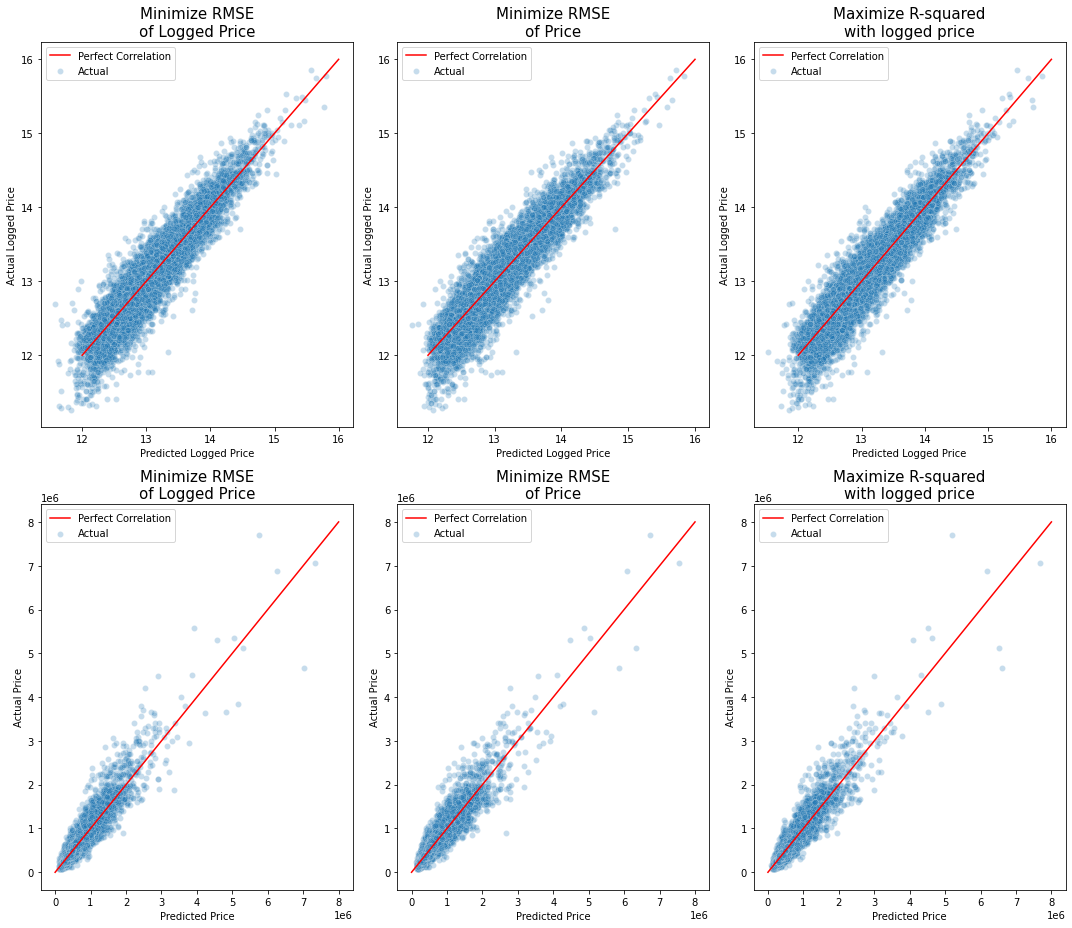

In [81]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize = (15, 13), ncols = 3, nrows = 2)

for model, ax, name in zip(three_models, axes[0], names):
    sns.scatterplot(x=model, y=y, alpha = 0.25, ax = ax, label='Actual')
    ax.set_title(name, fontsize = 15)
    ax.set_ylabel('Actual Logged Price')
    ax.set_xlabel('Predicted Logged Price')
    ax.plot([12,16], [12,16], color = 'red', label = 'Perfect Correlation')
    ax.legend()

for model, ax, name in zip(three_models, axes[1], names):
    sns.scatterplot(x=np.exp(model), y=np.exp(y), alpha = 0.25, ax = ax, label='Actual')
    ax.set_title(name, fontsize = 15)
    ax.set_ylabel('Actual Price')
    ax.set_xlabel('Predicted Price')
    ax.plot([0,8*10**6], [0,8*10**6], color = 'red', label = 'Perfect Correlation')
    ax.legend()
    
fig.tight_layout()

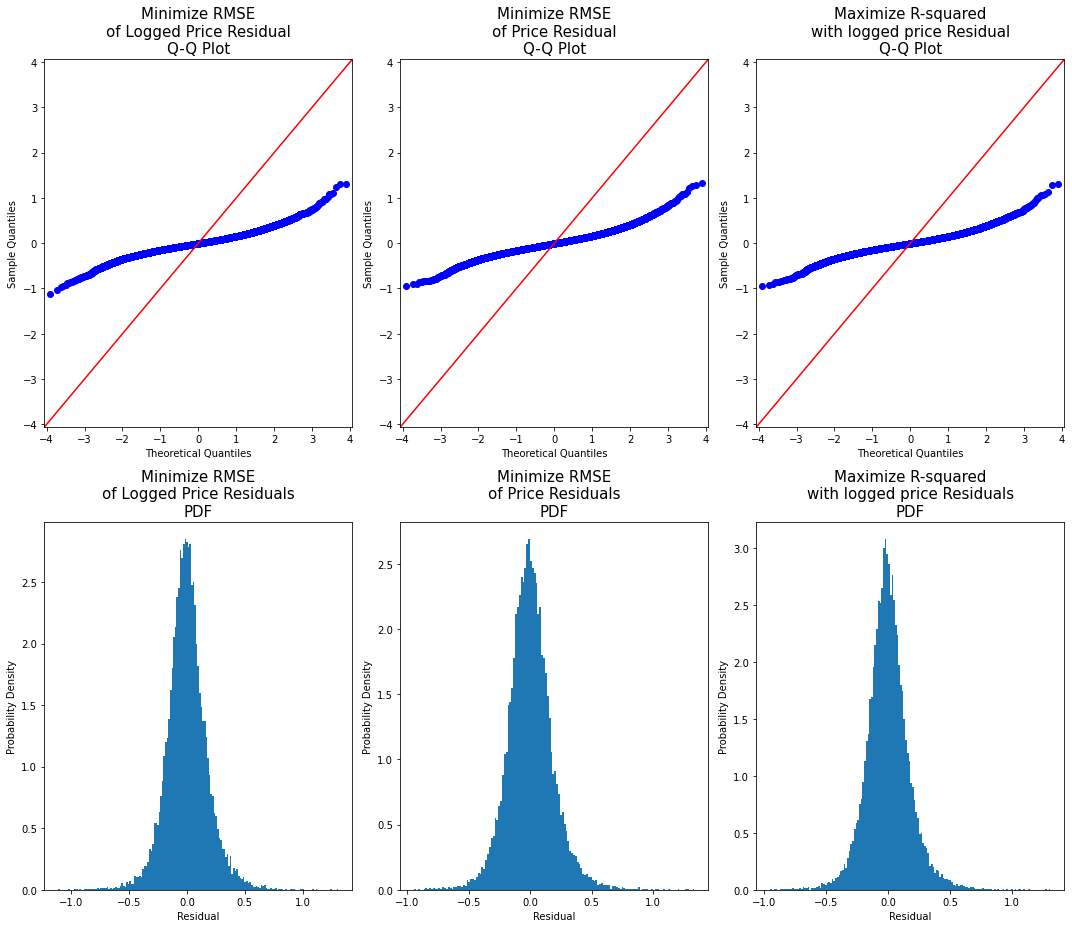

In [109]:
from statsmodels.graphics.gofplots import qqplot as qqplot
import scipy.stats as stats

fig, axes = plt.subplots(figsize = (15, 13), ncols = 3, nrows = 2)

for model, ax, name in zip(three_models, axes[0], names):
    qqplot(model-y, dist = stats.norm, line = '45', ax = ax)
    ax.set_title(name+' Residual\nQ-Q Plot', fontsize = 15)

for model, ax, name in zip(three_models, axes[1], names):
    ax.hist(model-y, bins = 'auto', density = True)
    ax.set_title(name+' Residuals\nPDF', fontsize = 15)
    ax.set_ylabel('Probability Density')
    ax.set_xlabel('Residual')
    
fig.tight_layout()